<a href="https://colab.research.google.com/github/Santi-P/coralvision/blob/main/CoralVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coral Classification
### Santi Pornavalai
### CSE 455 Project Winter 2022

In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms, io
from torchvision.utils import save_image
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import glob
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
print("Using device: ", device)

Using device:  cuda:0


Load the proprocessed Moorea Labeled Corals dataset from Googledrive

In [3]:
# Mount drive
# Only for my data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
!wget -O coral_data.tar.gz 'https://www.dropbox.com/s/uz8np9m3jw2m6xf/coral_data.tar.gz?dl=0'

--2022-03-15 03:40:48--  https://www.dropbox.com/s/uz8np9m3jw2m6xf/coral_data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uz8np9m3jw2m6xf/coral_data.tar.gz [following]
--2022-03-15 03:40:48--  https://www.dropbox.com/s/raw/uz8np9m3jw2m6xf/coral_data.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc467cf80547f79bdcacb719c5fb.dl.dropboxusercontent.com/cd/0/inline/Bhf-HI-jQ_OqWoPW5-bOm0MisVNbNV7gdEv_J6Vuk7B4jX8Kz9WB2HyTcNIYbF2j7Rgx36jJQVMhEjMYo_V2Yvzt3K1Nt1_eWg47rLwlhXPav0DhWDHq-O7Zjgg_xd2VJdgIm26Rm121NFsv45vOT9l7Vj614V5BzfRimBJghmMgcg/file# [following]
--2022-03-15 03:40:48--  https://uc467cf80547f79bdcacb719c5fb.dl.dropboxusercontent.com/cd/0/inline/Bhf-HI-jQ_OqWoPW5-bOm0MisVNbNV7gdEv_J6Vuk7B4jX8K

In [19]:
#Unzip data
%%shell
tar -xvf coral_data.tar.gz

Streaming output truncated to the last 5000 lines.
coral_patches_2009/12330.jpeg
coral_patches_2009/4521.jpeg
coral_patches_2009/63416.jpeg
coral_patches_2009/48741.jpeg
coral_patches_2009/59836.jpeg
coral_patches_2009/44417.jpeg
coral_patches_2009/58306.jpeg
coral_patches_2009/69902.jpeg
coral_patches_2009/14428.jpeg
coral_patches_2009/8225.jpeg
coral_patches_2009/5880.jpeg
coral_patches_2009/44694.jpeg
coral_patches_2009/24485.jpeg
coral_patches_2009/50193.jpeg
coral_patches_2009/32658.jpeg
coral_patches_2009/37085.jpeg
coral_patches_2009/55732.jpeg
coral_patches_2009/71615.jpeg
coral_patches_2009/64287.jpeg
coral_patches_2009/14684.jpeg
coral_patches_2009/26715.jpeg
coral_patches_2009/42764.jpeg
coral_patches_2009/70462.jpeg
coral_patches_2009/7897.jpeg
coral_patches_2009/64728.jpeg
coral_patches_2009/3252.jpeg
coral_patches_2009/3510.jpeg
coral_patches_2009/61451.jpeg
coral_patches_2009/33805.jpeg
coral_patches_2009/13843.jpeg
coral_patches_2009/17494.jpeg
coral_patches_2009/46766.

Create dataloader class for either 128x128 or stretched 224x224 for classification. 

In [5]:

class CoralPatches(Dataset):
    """Coral dataset."""

    def __init__(self, csv_file, root_dir, label_list, transform=None):

        self.landmarks_frame = pd.read_csv(csv_file)
        self.landmarks_frame['label'] = self.landmarks_frame['label'].str.lower()
        self.landmarks_frame = self.landmarks_frame[self.landmarks_frame['label'].isin(label_list)]

        self.root_dir = root_dir
        self.all_labels = label_list
        self.label_map = {i:l for l,i in enumerate(label_list)}
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                str(self.landmarks_frame.iloc[idx, 0])+'.jpeg')
        
        image = Image.open(img_name).convert('RGB')
        label = self.landmarks_frame.iloc[idx,1]

        if self.transform is not None:
            image = self.transform(image)
        
        sample = {'image': image, 'label':label, 'label_idx':self.label_map[label] }

        return sample

Transforms with normalization for pre-trained models. 

In [21]:
vanilla_transform = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),

        transforms.Normalize(
            [0.485, 0.456, 0.406], 
            [0.229, 0.224, 0.225])

    ]
)

In [3]:
google_net_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406], 
            [0.229, 0.224, 0.225])
    ]
)

Training and evaluation functions. Mostly taken from the transfer learning tutorial. 

In [11]:
def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch['image'].to(device), batch['label_idx'].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def train(net, dataloader,val_loader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in tqdm(enumerate(dataloader, 0), total = len(dataloader)):
        inputs, labels = batch['image'].to(device), batch['label_idx'].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    # show val accuracy for every epoch
    print("val accuracy: ", accuracy(net, val_loader))
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))

  return losses

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

def predict(net, dataloader):
  predictions = []
  ground_t = []
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch['image'].to(device), batch['label_idx'].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          predictions.extend(labels.tolist())
          ground_t.extend(predicted.tolist())

  return predictions, ground_t
  
def make_report(truth, preds):
  print(classification_report(truth, preds, target_names = label_list))
  conf_mat = confusion_matrix(truth, preds)
  conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
  conf_mat = np.around(conf_mat, decimals = 3)
  sns.heatmap(conf_mat,annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu")



Labels in the dataset. There are actually more than 9 labels however the baseline from the paper only uses these 9 labels. These labels however cover 96% of the dataset.

In [7]:
label_list = ['acrop','cca',  'macro',  'monti', 'pavon', 'pocill', 'porit',  'sand', 'turf']

Split dataset into training and validation. The data comes from pictures taken across 2 years. In this project I attempt to check across years (e.g train on 2008 and test on 2009). This is also one of the experiments from the original paper and system. 

In [25]:
### for 128 image
dataset_2008 = CoralPatches('coral_patches_2008.csv','coral_patches_2008', label_list, transform = vanilla_transform)
dataset_2009 = CoralPatches('coral_patches_2009.csv','coral_patches_2009', label_list,  transform = vanilla_transform)

N = (len(dataset_2008))
test_size = int(N * 0.90)
val_size = N - test_size
val_data_2008, data_2008 = random_split(dataset_2008,[val_size, test_size])
dataloader_2008 = DataLoader(data_2008,batch_size=32, shuffle=True)
val_loader_2008 = DataLoader(val_data_2008,batch_size=32)

N = (len(dataset_2009))
test_size = int(N * 0.90)
val_size = N - test_size
val_data_2009, data_2009 = random_split(dataset_2009,[val_size, test_size])
dataloader_2009 = DataLoader(data_2009,batch_size=32, shuffle=True)
val_loader_2009 = DataLoader(val_data_2009,batch_size=32)

In [ ]:
# standard simple CNN image classifier

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(13456, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
simple_net = Net()
simple_net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)

In [ ]:
simple_net_losses = train(simple_net, dataloader_2008, val_loader_2008, epochs=10, schedule={0:.01, 1:.001, 3:.0001}, print_every=500)

Learning rate: 0.010000


 14%|█▎        | 501/3680 [00:43<04:04, 13.01it/s]

[0,   500] loss: 1.510


 27%|██▋       | 1001/3680 [01:20<03:14, 13.78it/s]

[0,  1000] loss: 1.367


 41%|████      | 1503/3680 [01:54<02:24, 15.04it/s]

[0,  1500] loss: 1.283


 54%|█████▍    | 2003/3680 [02:25<01:37, 17.11it/s]

[0,  2000] loss: 1.263


 68%|██████▊   | 2503/3680 [02:54<01:04, 18.12it/s]

[0,  2500] loss: 1.226


 82%|████████▏ | 3003/3680 [03:20<00:35, 19.06it/s]

[0,  3000] loss: 1.197


 95%|█████████▌| 3502/3680 [03:47<00:09, 19.29it/s]

[0,  3500] loss: 1.179


100%|██████████| 3680/3680 [03:56<00:00, 15.57it/s]


val accuracy:  0.6175661213881669
Learning rate: 0.001000


 14%|█▎        | 503/3680 [00:23<02:31, 20.94it/s]

[1,   500] loss: 1.040


 27%|██▋       | 1004/3680 [00:47<02:05, 21.26it/s]

[1,  1000] loss: 1.021


 41%|████      | 1502/3680 [01:11<01:44, 20.83it/s]

[1,  1500] loss: 1.009


 54%|█████▍    | 2003/3680 [01:34<01:17, 21.54it/s]

[1,  2000] loss: 1.003


 68%|██████▊   | 2504/3680 [01:57<00:53, 21.85it/s]

[1,  2500] loss: 1.002


 82%|████████▏ | 3002/3680 [02:20<00:30, 21.99it/s]

[1,  3000] loss: 1.003


 95%|█████████▌| 3503/3680 [02:44<00:08, 22.09it/s]

[1,  3500] loss: 0.987


100%|██████████| 3680/3680 [02:52<00:00, 21.37it/s]


val accuracy:  0.6584620088671457


 14%|█▎        | 504/3680 [00:23<02:24, 22.02it/s]

[2,   500] loss: 0.948


 27%|██▋       | 1002/3680 [00:45<02:03, 21.65it/s]

[2,  1000] loss: 0.957


 41%|████      | 1503/3680 [01:08<01:41, 21.54it/s]

[2,  1500] loss: 0.951


 54%|█████▍    | 2004/3680 [01:31<01:20, 20.94it/s]

[2,  2000] loss: 0.943


 68%|██████▊   | 2504/3680 [01:54<00:55, 21.25it/s]

[2,  2500] loss: 0.944


 82%|████████▏ | 3002/3680 [02:17<00:32, 20.70it/s]

[2,  3000] loss: 0.933


 95%|█████████▌| 3503/3680 [02:41<00:08, 21.53it/s]

[2,  3500] loss: 0.927


100%|██████████| 3680/3680 [02:49<00:00, 21.70it/s]


val accuracy:  0.6666411863629415
Learning rate: 0.000100


 14%|█▎        | 504/3680 [00:23<02:28, 21.41it/s]

[3,   500] loss: 0.846


 27%|██▋       | 1002/3680 [00:45<02:00, 22.24it/s]

[3,  1000] loss: 0.859


 41%|████      | 1503/3680 [01:08<01:34, 22.92it/s]

[3,  1500] loss: 0.876


 54%|█████▍    | 2004/3680 [01:31<01:15, 22.05it/s]

[3,  2000] loss: 0.851


 68%|██████▊   | 2502/3680 [01:54<00:52, 22.38it/s]

[3,  2500] loss: 0.871


 82%|████████▏ | 3003/3680 [02:17<00:32, 21.07it/s]

[3,  3000] loss: 0.852


 95%|█████████▌| 3504/3680 [02:39<00:07, 22.68it/s]

[3,  3500] loss: 0.854


100%|██████████| 3680/3680 [02:47<00:00, 21.93it/s]


val accuracy:  0.6725271365234674


 14%|█▎        | 504/3680 [00:27<02:18, 22.85it/s]

[4,   500] loss: 0.861


 27%|██▋       | 1004/3680 [00:54<02:01, 22.10it/s]

[4,  1000] loss: 0.851


 41%|████      | 1502/3680 [01:17<01:40, 21.64it/s]

[4,  1500] loss: 0.835


 54%|█████▍    | 2003/3680 [01:41<01:14, 22.41it/s]

[4,  2000] loss: 0.836


 68%|██████▊   | 2501/3680 [02:04<00:54, 21.65it/s]

[4,  2500] loss: 0.844


 82%|████████▏ | 3002/3680 [02:27<00:30, 22.08it/s]

[4,  3000] loss: 0.837


 95%|█████████▌| 3503/3680 [02:50<00:07, 22.18it/s]

[4,  3500] loss: 0.847


100%|██████████| 3680/3680 [02:58<00:00, 20.67it/s]


val accuracy:  0.67283290016817


 14%|█▎        | 504/3680 [00:22<02:26, 21.71it/s]

[5,   500] loss: 0.836


 27%|██▋       | 1002/3680 [00:45<02:01, 21.97it/s]

[5,  1000] loss: 0.820


 41%|████      | 1503/3680 [01:08<01:38, 22.02it/s]

[5,  1500] loss: 0.838


 54%|█████▍    | 2004/3680 [01:30<01:18, 21.33it/s]

[5,  2000] loss: 0.841


 68%|██████▊   | 2502/3680 [01:53<00:54, 21.78it/s]

[5,  2500] loss: 0.838


 82%|████████▏ | 3003/3680 [02:16<00:31, 21.22it/s]

[5,  3000] loss: 0.835


 95%|█████████▌| 3504/3680 [02:38<00:08, 21.85it/s]

[5,  3500] loss: 0.814


100%|██████████| 3680/3680 [02:46<00:00, 22.10it/s]


val accuracy:  0.6745910411252102


 14%|█▎        | 504/3680 [00:22<02:22, 22.33it/s]

[6,   500] loss: 0.822


 27%|██▋       | 1002/3680 [00:45<01:59, 22.43it/s]

[6,  1000] loss: 0.818


 41%|████      | 1503/3680 [01:07<01:38, 22.17it/s]

[6,  1500] loss: 0.818


 54%|█████▍    | 2004/3680 [01:30<01:11, 23.28it/s]

[6,  2000] loss: 0.835


 68%|██████▊   | 2502/3680 [01:52<00:52, 22.55it/s]

[6,  2500] loss: 0.797


 82%|████████▏ | 3003/3680 [02:14<00:30, 22.35it/s]

[6,  3000] loss: 0.831


 95%|█████████▌| 3504/3680 [02:37<00:07, 22.63it/s]

[6,  3500] loss: 0.813


100%|██████████| 3680/3680 [02:44<00:00, 22.34it/s]


val accuracy:  0.6763491820822504


 14%|█▎        | 502/3680 [00:23<02:26, 21.76it/s]

[7,   500] loss: 0.807


 27%|██▋       | 1003/3680 [00:46<01:57, 22.87it/s]

[7,  1000] loss: 0.815


 41%|████      | 1504/3680 [01:08<01:38, 22.00it/s]

[7,  1500] loss: 0.799


 54%|█████▍    | 2002/3680 [01:31<01:14, 22.51it/s]

[7,  2000] loss: 0.810


 68%|██████▊   | 2503/3680 [01:53<00:52, 22.30it/s]

[7,  2500] loss: 0.792


 82%|████████▏ | 3004/3680 [02:15<00:30, 22.51it/s]

[7,  3000] loss: 0.796


 95%|█████████▌| 3502/3680 [02:37<00:08, 21.30it/s]

[7,  3500] loss: 0.808


100%|██████████| 3680/3680 [02:45<00:00, 22.21it/s]


val accuracy:  0.6748203638587372


 14%|█▎        | 504/3680 [00:22<02:21, 22.42it/s]

[8,   500] loss: 0.797


 27%|██▋       | 1002/3680 [00:45<01:59, 22.41it/s]

[8,  1000] loss: 0.788


 41%|████      | 1503/3680 [01:07<01:36, 22.67it/s]

[8,  1500] loss: 0.793


 54%|█████▍    | 2004/3680 [01:29<01:15, 22.26it/s]

[8,  2000] loss: 0.782


 68%|██████▊   | 2502/3680 [01:52<00:52, 22.36it/s]

[8,  2500] loss: 0.798


 82%|████████▏ | 3003/3680 [02:14<00:31, 21.61it/s]

[8,  3000] loss: 0.778


 95%|█████████▌| 3504/3680 [02:36<00:07, 22.51it/s]

[8,  3500] loss: 0.796


100%|██████████| 3680/3680 [02:44<00:00, 22.37it/s]


val accuracy:  0.6722978137899404


 14%|█▎        | 504/3680 [00:22<02:25, 21.82it/s]

[9,   500] loss: 0.769


 27%|██▋       | 1002/3680 [00:44<01:55, 23.20it/s]

[9,  1000] loss: 0.773


 41%|████      | 1503/3680 [01:07<01:34, 23.11it/s]

[9,  1500] loss: 0.768


 54%|█████▍    | 2004/3680 [01:29<01:17, 21.74it/s]

[9,  2000] loss: 0.773


 68%|██████▊   | 2502/3680 [01:51<00:54, 21.68it/s]

[9,  2500] loss: 0.781


 82%|████████▏ | 3003/3680 [02:14<00:30, 22.45it/s]

[9,  3000] loss: 0.778


 95%|█████████▌| 3504/3680 [02:36<00:07, 22.10it/s]

[9,  3500] loss: 0.771


100%|██████████| 3680/3680 [02:44<00:00, 22.40it/s]


val accuracy:  0.6755083320593182


In [ ]:
simple_truth, simple_preds = predict(simple_net, dataloader_2009)

              precision    recall  f1-score   support

       acrop       0.11      0.19      0.14       151
         cca       0.63      0.80      0.71     30723
       macro       0.65      0.48      0.55      5987
       monti       0.01      0.00      0.00       699
       pavon       0.03      0.02      0.02       535
      pocill       0.22      0.34      0.27      1207
       porit       0.65      0.57      0.60      6697
        sand       0.57      0.51      0.54      4655
        turf       0.40      0.22      0.28     11299

    accuracy                           0.59     61953
   macro avg       0.36      0.35      0.35     61953
weighted avg       0.57      0.59      0.57     61953



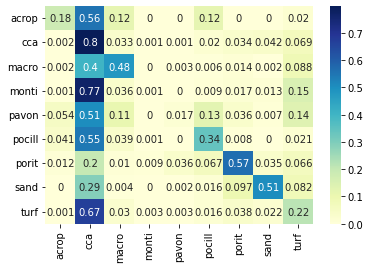

In [ ]:
make_report(simple_truth, simple_preds)

In [ ]:
# resnet18 pre-trained classifier
resnet18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet18.fc = torch.nn.Linear(512, 9)
resnet18.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
resnet_losses = train(resnet18, dataloader_2008, val_loader_2008, epochs=5, schedule={0:.01, 1:.001, 3:.0001}, print_every=500)

Learning rate: 0.010000


 14%|█▎        | 501/3680 [00:37<03:55, 13.50it/s]

[0,   500] loss: 1.197


 27%|██▋       | 1001/3680 [01:14<03:20, 13.36it/s]

[0,  1000] loss: 0.873


 41%|████      | 1501/3680 [01:51<02:41, 13.53it/s]

[0,  1500] loss: 0.791


 54%|█████▍    | 2001/3680 [02:27<02:03, 13.56it/s]

[0,  2000] loss: 0.746


 68%|██████▊   | 2501/3680 [03:04<01:27, 13.41it/s]

[0,  2500] loss: 0.706


 82%|████████▏ | 3001/3680 [03:41<00:50, 13.46it/s]

[0,  3000] loss: 0.721


 95%|█████████▌| 3501/3680 [04:18<00:13, 13.32it/s]

[0,  3500] loss: 0.692


100%|██████████| 3680/3680 [04:31<00:00, 13.55it/s]


val accuracy:  0.6718391683228864
Learning rate: 0.010000


 14%|█▎        | 502/3680 [00:36<03:53, 13.61it/s]

[1,   500] loss: 1.381


 27%|██▋       | 1002/3680 [01:13<03:19, 13.46it/s]

[1,  1000] loss: 0.993


 41%|████      | 1502/3680 [01:50<02:40, 13.58it/s]

[1,  1500] loss: 0.868


 54%|█████▍    | 2002/3680 [02:27<02:07, 13.13it/s]

[1,  2000] loss: 0.791


 68%|██████▊   | 2502/3680 [03:04<01:27, 13.48it/s]

[1,  2500] loss: 0.767


 82%|████████▏ | 3002/3680 [03:40<00:50, 13.49it/s]

[1,  3000] loss: 0.748


 95%|█████████▌| 3502/3680 [04:17<00:13, 13.60it/s]

[1,  3500] loss: 0.718


100%|██████████| 3680/3680 [04:30<00:00, 13.59it/s]


val accuracy:  0.7336034245528207


 14%|█▎        | 502/3680 [00:36<03:55, 13.52it/s]

[2,   500] loss: 0.684


 27%|██▋       | 1002/3680 [01:13<03:18, 13.48it/s]

[2,  1000] loss: 0.660


 41%|████      | 1502/3680 [01:50<02:41, 13.48it/s]

[2,  1500] loss: 0.672


 54%|█████▍    | 2002/3680 [02:27<02:03, 13.55it/s]

[2,  2000] loss: 0.668


 68%|██████▊   | 2502/3680 [03:04<01:27, 13.52it/s]

[2,  2500] loss: 0.671


 82%|████████▏ | 3002/3680 [03:41<00:52, 12.99it/s]

[2,  3000] loss: 0.655


 95%|█████████▌| 3502/3680 [04:18<00:12, 13.70it/s]

[2,  3500] loss: 0.648


100%|██████████| 3680/3680 [04:31<00:00, 13.55it/s]


val accuracy:  0.7521021250573307
Learning rate: 0.000100


 14%|█▎        | 502/3680 [00:37<03:58, 13.33it/s]

[3,   500] loss: 0.549


 27%|██▋       | 1002/3680 [01:14<03:21, 13.30it/s]

[3,  1000] loss: 0.502


 41%|████      | 1502/3680 [01:50<02:41, 13.51it/s]

[3,  1500] loss: 0.501


 54%|█████▍    | 2002/3680 [02:27<02:04, 13.43it/s]

[3,  2000] loss: 0.501


 68%|██████▊   | 2502/3680 [03:04<01:27, 13.47it/s]

[3,  2500] loss: 0.480


 82%|████████▏ | 3002/3680 [03:41<00:50, 13.44it/s]

[3,  3000] loss: 0.475


 95%|█████████▌| 3502/3680 [04:18<00:13, 13.37it/s]

[3,  3500] loss: 0.469


100%|██████████| 3680/3680 [04:31<00:00, 13.57it/s]


val accuracy:  0.8089741629720226


 14%|█▎        | 502/3680 [00:36<03:43, 14.21it/s]

[4,   500] loss: 0.477


 27%|██▋       | 1002/3680 [01:12<03:15, 13.69it/s]

[4,  1000] loss: 0.475


 41%|████      | 1502/3680 [01:48<02:35, 13.98it/s]

[4,  1500] loss: 0.466


 54%|█████▍    | 2002/3680 [02:23<01:59, 14.07it/s]

[4,  2000] loss: 0.474


 68%|██████▊   | 2502/3680 [02:59<01:26, 13.60it/s]

[4,  2500] loss: 0.457


 82%|████████▏ | 3002/3680 [03:35<00:48, 13.90it/s]

[4,  3000] loss: 0.464


 95%|█████████▌| 3502/3680 [04:10<00:12, 14.25it/s]

[4,  3500] loss: 0.449


100%|██████████| 3680/3680 [04:22<00:00, 14.00it/s]


val accuracy:  0.8147836722213728


              precision    recall  f1-score   support

       acrop       0.64      0.50      0.56       189
         cca       0.88      0.70      0.78     38899
       macro       0.65      0.73      0.69      5302
       monti       0.15      0.19      0.17       544
       pavon       0.32      0.79      0.46       223
      pocill       0.75      0.86      0.80      1056
       porit       0.81      0.82      0.81      6616
        sand       0.68      0.74      0.71      4279
        turf       0.27      0.63      0.38      4845

    accuracy                           0.71     61953
   macro avg       0.57      0.66      0.59     61953
weighted avg       0.78      0.71      0.73     61953



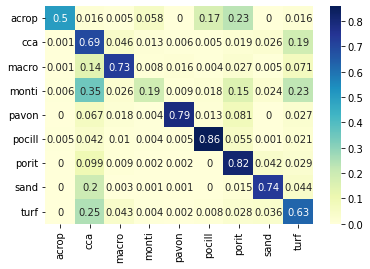

In [ ]:
preds, truth = predict(resnet18, dataloader_2009)
make_report(truth, preds)

In [8]:
# Loader for 224 image
dataset_2008 = CoralPatches('coral_patches_2008.csv','coral_patches_2008', label_list, transform = google_net_transform)
dataset_2009 = CoralPatches('coral_patches_2009.csv','coral_patches_2009', label_list,  transform = google_net_transform)

N = (len(dataset_2008))
test_size = int(N * 0.90)
val_size = N - test_size
val_data_2008, data_2008 = random_split(dataset_2008,[val_size, test_size])
dataloader_2008 = DataLoader(data_2008,batch_size=32, shuffle=True)
val_loader_2008 = DataLoader(val_data_2008,batch_size=32)

N = (len(dataset_2009))
test_size = int(N * 0.90)
val_size = N - test_size
val_data_2009, data_2009 = random_split(dataset_2009,[val_size, test_size])
dataloader_2009 = DataLoader(data_2009,batch_size=32, shuffle=True)
val_loader_2009 = DataLoader(val_data_2009,batch_size=32)

Load GoogLeNet pre-trained model and replace final layer to match number of labels. 

In [ ]:
ggnet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
ggnet.fc = torch.nn.Linear(1024, 9)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
ggnet_losses = train(ggnet, dataloader_2008, val_loader_2008, epochs=5, schedule={0:.01, 1:.001, 3:.0001}, print_every=500)

Learning rate: 0.010000


 14%|█▎        | 501/3680 [01:26<09:04,  5.84it/s]

[0,   500] loss: 0.955


 27%|██▋       | 1001/3680 [02:52<07:43,  5.79it/s]

[0,  1000] loss: 0.738


 41%|████      | 1501/3680 [04:18<06:17,  5.77it/s]

[0,  1500] loss: 0.681


 54%|█████▍    | 2001/3680 [05:44<04:50,  5.77it/s]

[0,  2000] loss: 0.645


 68%|██████▊   | 2501/3680 [07:10<03:24,  5.76it/s]

[0,  2500] loss: 0.633


 82%|████████▏ | 3001/3680 [08:36<01:56,  5.83it/s]

[0,  3000] loss: 0.608


 95%|█████████▌| 3501/3680 [10:01<00:30,  5.90it/s]

[0,  3500] loss: 0.586


100%|██████████| 3680/3680 [10:31<00:00,  5.82it/s]


val accuracy:  0.7528665341690873
Learning rate: 0.001000


 14%|█▎        | 501/3680 [01:25<09:03,  5.85it/s]

[1,   500] loss: 0.502


 27%|██▋       | 1001/3680 [02:51<07:40,  5.82it/s]

[1,  1000] loss: 0.489


 41%|████      | 1501/3680 [04:16<06:13,  5.83it/s]

[1,  1500] loss: 0.462


 54%|█████▍    | 2001/3680 [05:40<04:41,  5.96it/s]

[1,  2000] loss: 0.466


 68%|██████▊   | 2501/3680 [07:04<03:16,  6.01it/s]

[1,  2500] loss: 0.473


 82%|████████▏ | 3001/3680 [08:29<01:55,  5.89it/s]

[1,  3000] loss: 0.456


 95%|█████████▌| 3501/3680 [09:53<00:30,  5.91it/s]

[1,  3500] loss: 0.454


100%|██████████| 3680/3680 [10:23<00:00,  5.90it/s]


val accuracy:  0.8238801406512766


 14%|█▎        | 501/3680 [01:26<08:46,  6.04it/s]

[2,   500] loss: 0.434


 27%|██▋       | 1001/3680 [02:51<07:40,  5.81it/s]

[2,  1000] loss: 0.427


 41%|████      | 1501/3680 [04:15<06:04,  5.97it/s]

[2,  1500] loss: 0.442


 54%|█████▍    | 2001/3680 [05:40<04:48,  5.82it/s]

[2,  2000] loss: 0.433


 68%|██████▊   | 2501/3680 [07:04<03:19,  5.90it/s]

[2,  2500] loss: 0.427


 82%|████████▏ | 3001/3680 [08:28<01:55,  5.90it/s]

[2,  3000] loss: 0.438


 95%|█████████▌| 3501/3680 [09:53<00:30,  5.92it/s]

[2,  3500] loss: 0.426


100%|██████████| 3680/3680 [10:23<00:00,  5.90it/s]


val accuracy:  0.8208989451154258
Learning rate: 0.000100


 14%|█▎        | 501/3680 [01:25<09:04,  5.84it/s]

[3,   500] loss: 0.359


 27%|██▋       | 1001/3680 [02:51<07:30,  5.95it/s]

[3,  1000] loss: 0.348


 41%|████      | 1501/3680 [04:16<06:08,  5.92it/s]

[3,  1500] loss: 0.351


 54%|█████▍    | 2001/3680 [05:40<04:39,  6.01it/s]

[3,  2000] loss: 0.349


 68%|██████▊   | 2501/3680 [07:04<03:19,  5.92it/s]

[3,  2500] loss: 0.351


 82%|████████▏ | 3001/3680 [08:29<02:09,  5.26it/s]

[3,  3000] loss: 0.358


 95%|█████████▌| 3501/3680 [09:56<00:31,  5.68it/s]

[3,  3500] loss: 0.340


100%|██████████| 3680/3680 [10:28<00:00,  5.86it/s]


val accuracy:  0.8350405136829231


 14%|█▎        | 501/3680 [01:26<08:55,  5.94it/s]

[4,   500] loss: 0.352


 27%|██▋       | 1001/3680 [02:52<08:17,  5.39it/s]

[4,  1000] loss: 0.340


 41%|████      | 1501/3680 [04:18<06:11,  5.86it/s]

[4,  1500] loss: 0.334


 54%|█████▍    | 2001/3680 [05:43<04:46,  5.86it/s]

[4,  2000] loss: 0.342


 68%|██████▊   | 2501/3680 [07:09<03:16,  6.01it/s]

[4,  2500] loss: 0.339


 82%|████████▏ | 3001/3680 [08:34<02:05,  5.41it/s]

[4,  3000] loss: 0.335


 95%|█████████▌| 3501/3680 [09:59<00:32,  5.55it/s]

[4,  3500] loss: 0.341


100%|██████████| 3680/3680 [10:29<00:00,  5.85it/s]


val accuracy:  0.8392447637975845


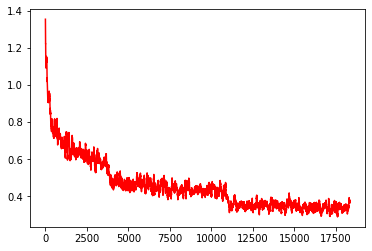

In [ ]:
plt.plot(smooth(ggnet_losses,50), 'r-')

In [ ]:
# predict on 2009 dataset
truth, preds = predict(ggnet, dataloader_2009)

              precision    recall  f1-score   support

       acrop       0.46      0.87      0.60       154
         cca       0.73      0.88      0.80     30769
       macro       0.77      0.71      0.74      5938
       monti       0.34      0.38      0.36       690
       pavon       0.91      0.54      0.68       545
      pocill       0.85      0.82      0.83      1218
       porit       0.89      0.84      0.86      6684
        sand       0.75      0.75      0.75      4663
        turf       0.70      0.34      0.46     11292

    accuracy                           0.74     61953
   macro avg       0.71      0.68      0.68     61953
weighted avg       0.74      0.74      0.73     61953



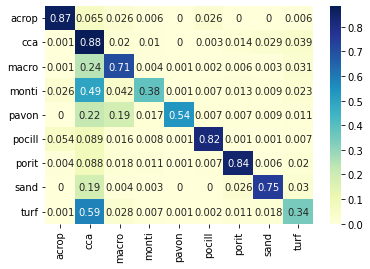

In [ ]:
# report for googlenet 
make_report(truth, preds)

In [9]:
# resnet18 pre-trained classifier
resnet152 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
resnet152.fc = torch.nn.Linear(2048, 9)
resnet152.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
resnet152_losses = train(resnet152, dataloader_2008, val_loader_2008, epochs=5, schedule={0:.01, 1:.001, 3:.0001}, print_every=500)

Learning rate: 0.010000


 14%|█▎        | 500/3680 [03:38<23:14,  2.28it/s]

[0,   500] loss: 1.138


 27%|██▋       | 1000/3680 [07:17<19:39,  2.27it/s]

[0,  1000] loss: 0.812


 41%|████      | 1500/3680 [10:55<15:52,  2.29it/s]

[0,  1500] loss: 0.730


 54%|█████▍    | 2000/3680 [14:33<12:13,  2.29it/s]

[0,  2000] loss: 0.665


 68%|██████▊   | 2500/3680 [18:11<08:36,  2.28it/s]

[0,  2500] loss: 0.652


 82%|████████▏ | 3000/3680 [21:50<04:57,  2.29it/s]

[0,  3000] loss: 0.690


 95%|█████████▌| 3500/3680 [25:29<01:18,  2.28it/s]

[0,  3500] loss: 0.652


100%|██████████| 3680/3680 [26:47<00:00,  2.29it/s]


val accuracy:  0.7900168170004587
Learning rate: 0.001000


 14%|█▎        | 500/3680 [03:36<22:49,  2.32it/s]

[1,   500] loss: 0.562


 27%|██▋       | 1000/3680 [07:12<19:16,  2.32it/s]

[1,  1000] loss: 0.536


 41%|████      | 1500/3680 [10:48<15:40,  2.32it/s]

[1,  1500] loss: 0.499


 54%|█████▍    | 2000/3680 [14:24<12:05,  2.32it/s]

[1,  2000] loss: 0.503


 68%|██████▊   | 2500/3680 [18:00<08:29,  2.32it/s]

[1,  2500] loss: 0.466


 82%|████████▏ | 3000/3680 [21:37<04:53,  2.32it/s]

[1,  3000] loss: 0.487


 95%|█████████▌| 3500/3680 [25:13<01:17,  2.31it/s]

[1,  3500] loss: 0.493


100%|██████████| 3680/3680 [26:30<00:00,  2.31it/s]


val accuracy:  0.8290016817000458


 14%|█▎        | 500/3680 [03:35<22:44,  2.33it/s]

[2,   500] loss: 0.448


 27%|██▋       | 1000/3680 [07:10<19:22,  2.31it/s]

[2,  1000] loss: 0.441


 41%|████      | 1500/3680 [10:46<15:35,  2.33it/s]

[2,  1500] loss: 0.448


 54%|█████▍    | 2000/3680 [14:21<12:04,  2.32it/s]

[2,  2000] loss: 0.443


 68%|██████▊   | 2500/3680 [17:57<08:27,  2.32it/s]

[2,  2500] loss: 0.437


 82%|████████▏ | 3000/3680 [21:33<04:52,  2.32it/s]

[2,  3000] loss: 0.448


 95%|█████████▌| 3500/3680 [25:09<01:17,  2.32it/s]

[2,  3500] loss: 0.451


100%|██████████| 3680/3680 [26:26<00:00,  2.32it/s]


val accuracy:  0.8297660908118025
Learning rate: 0.000100


 14%|█▎        | 500/3680 [03:35<22:45,  2.33it/s]

[3,   500] loss: 0.348


 27%|██▋       | 1000/3680 [07:11<19:15,  2.32it/s]

[3,  1000] loss: 0.347


 38%|███▊      | 1400/3680 [10:03<16:19,  2.33it/s]

              precision    recall  f1-score   support

       acrop       0.47      0.41      0.44        22
         cca       0.88      0.69      0.77      4346
       macro       0.64      0.73      0.68       579
       monti       0.12      0.20      0.15        49
       pavon       0.24      0.59      0.34        22
      pocill       0.75      0.82      0.79       119
       porit       0.83      0.82      0.82       753
        sand       0.66      0.73      0.69       457
        turf       0.26      0.63      0.37       537

    accuracy                           0.70      6884
   macro avg       0.54      0.62      0.56      6884
weighted avg       0.78      0.70      0.73      6884



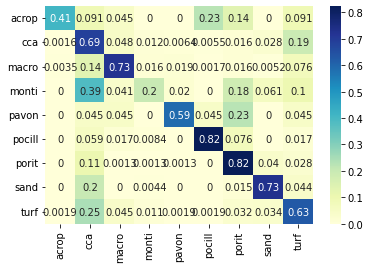

In [ ]:
conf_mat = confusion_matrix(truth, preds)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_mat,annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu")

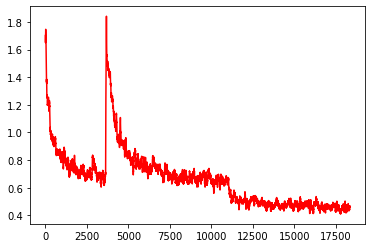

In [ ]:
plt.plot(smooth(losses,50), 'r-')


In [ ]:
accuracy(resnet_18, dataloader_2009)

0.7067131535196036